In [2539]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from config import api_key
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy
%matplotlib inline

In [2540]:
quandl.ApiConfig.api_key = api_key
#Variance Risk Premium: https://sites.google.com/site/haozhouspersonalhomepage
#EOM Nominal S&P, Nominal Dividends / Nominal Risk Free Rate: http://www.hec.unil.ch/agoyal/
#Consumer Sentiment: http://www.sca.isr.umich.edu/

In [2541]:
ticker = 'SPY'
transform = 'normalize'
start_date = '2018-01-01'
end_date = '2018-12-31'
period = 'monthly'

In [2542]:
#Access data from Quandl
ticker_data = quandl.get('EOD/' + ticker, start_date=start_date, end_date=end_date, collapse=period)
risk_free_rate = quandl.get('FRED/DTB3', start_date=start_date, end_date=end_date, collapse=period)
fed_funds_rate = quandl.get('FRED/FEDFUNDS', start_date=start_date, end_date=end_date, collapse=period)

#Confirm results are same size:
if ticker_data.shape[0] == risk_free_rate.shape[0] == fed_funds_rate.shape[0]:
    
    print(f"All dataframes are {ticker_data.shape[0]} rows")

else:
    print('Dataframes are not the same size:',  
          f'ticker_data is {ticker_data.shape[0]}, ',
          f'risk_free_rate is {risk_free_rate.shape[0]}, ',
          f'fed_funds_rate is {fed_funds_rate.shape[0]}.')

All dataframes are 12 rows


In [2543]:
#Make Function to Create Return Column for Risk Free Rate & Fed Funds Rate
def make_return_column(data):
    
    list_return = []

    for i in range(len(data)):
        x = (data.iloc[i]['Value']/12)/100
        list_return.append(x)
        
    temp_df = pd.DataFrame(list_return)
    
    data = pd.concat([data.reset_index(), temp_df.reset_index(drop=True)], axis=1)
    data = data.rename(columns={0: 'return'})
    
    return data

risk_free_df = make_return_column(risk_free_rate)
fed_funds_df = make_return_column(fed_funds_rate)

In [2544]:
"""
Monthly >>>
Index: S&P 500 Index Data
D12: Dividends are 12-month moving sums of dividends paid on the S&P 500 index (Goyal, Welch) 
     -- Confirmed with Y Charts
Rfree: Nominal Risk Free Rate
"""
goyal = pd.read_excel('PredictorData2017.xlsx')
df = pd.DataFrame(goyal)
df.tail(12)

'\nMonthly >>>\nIndex: S&P 500 Index Data\nD12: Dividends are 12-month moving sums of dividends paid on the S&P 500 index (Goyal, Welch) \n     -- Confirmed with Y Charts\nRfree: Nominal Risk Free Rate\n'

,yyyymm,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx
1752,201701,2278.870117,45.927877,96.463333,0.291980,0.0051,0.0392,0.0466,0.0278,-0.022562,0.000425,0.005828,0.0043,-0.0021,0.000331,NaN,0.019384,0.018311
1753,201702,2363.639893,46.155150,98.376667,0.278678,0.0052,0.0395,0.0464,0.0270,-0.018621,0.000433,0.003146,0.0137,0.0212,0.000224,NaN,0.039459,0.037052
1754,201703,2362.719971,46.382424,100.290000,0.281599,0.0074,0.0401,0.0468,0.0274,-0.016151,0.000617,0.000813,-0.0040,-0.0062,0.000563,NaN,0.001664,0.000055
1755,201704,2384.199951,46.661289,101.533333,0.277870,0.0080,0.0387,0.0457,0.0265,-0.015497,0.000667,0.002966,0.0145,0.0176,0.000384,NaN,0.010591,0.009439
1756,201705,2411.800049,46.940154,102.776667,0.276969,0.0089,0.0385,0.0455,0.0256,-0.010100,0.000742,0.000855,0.0158,0.0226,0.000502,NaN,0.014552,0.011920
1757,201706,2423.409912,47.219019,104.020000,0.272545,0.0098,0.0368,0.0437,0.0258,-0.009702,0.000817,0.000907,-0.0010,0.0108,0.000450,NaN,0.005798,0.004364
1758,201707,2470.300049,47.537047,105.040000,0.265804,0.0107,0.0370,0.0439,0.0262,-0.013104,0.000892,-0.000690,-0.0027,0.0060,0.000258,NaN,0.020696,0.019162
1759,201708,2471.649902,47.855075,106.060000,0.265114,0.0101,0.0363,0.0431,0.0242,-0.012138,0.000842,0.002994,0.0289,0.0153,0.000753,NaN,0.002238,-0.000324
1760,201709,2519.360107,48.173103,107.080000,0.259706,0.0103,0.0363,0.0430,0.0259,-0.011027,0.000858,0.005295,-0.0205,-0.0037,0.000251,NaN,0.020050,0.018742
1761,201710,2575.260010,48.426075,108.013333,0.248906,0.0107,0.0360,0.0432,0.0261,-0.012358,0.000892,-0.000632,-0.0013,0.0076,0.000224,NaN,0.024158,0.023006


In [2545]:
#New DF with cleaned up Columns
df_cols = ['yyyymm', 'Index', 'D12', 'Rfree']
df = df[df_cols]

#Convert yyyymm to Datetime then to Period
yyyymm = pd.to_datetime(df['yyyymm'], format='%Y%m').dt.strftime('%Y-%m')
periods = pd.to_datetime(yyyymm, format='%Y-%m')
df['yyyymm'] = periods

#Drop rows prior to 1990-01
df = df[df['yyyymm'] >= '1990-01']

In [2546]:
"""
VRP: Variance Risk Premium = IV - RV
IV: Implied Variance = VIX-Squared/12
RV: Realized Variance = Sum of Squared 5-minute log returns of the S&P 500 Index
"""
vrp = pd.read_fwf('VRPtable.txt')
df_vrp = pd.DataFrame(vrp)
df_vrp.tail(10)
df_vrp.shape

'\nVRP: Variance Risk Premium = IV - RV\nIV: Implied Variance = VIX-Squared/12\nRV: Realized Variance = Sum of Squared 5-minute log returns of the S&P 500 Index\n'

,Year,Month,VRP,EVRP,IV,RV,ERV
338,2018,3,8.6653,5.7620,33.2334,24.5681,27.4714
339,2018,4,-1.9751,-8.2494,21.1471,23.1221,29.3964
340,2018,5,9.4048,3.2582,19.8404,10.4356,16.5822
341,2018,6,13.2745,5.0526,21.5740,8.2995,16.5214
342,2018,7,8.1409,-4.8897,13.7174,5.5765,18.6072
343,2018,8,8.5030,3.3157,13.7816,5.2786,10.4659
344,2018,9,7.9528,1.6749,12.2412,4.2884,10.5663
345,2018,10,-2.2509,28.5411,37.5594,39.8103,9.0183
346,2018,11,2.7329,-5.2160,27.2104,24.4775,32.4264
347,2018,12,-4.0034,30.9039,53.8480,57.8514,22.9441


(348, 7)

In [2547]:
#Drop 2018 Rows
df_vrp = df_vrp[df_vrp['Year'] < 2018]

In [2548]:
#Drop Unnecessary Columns
df_vrp = df_vrp[['VRP']]

In [2549]:
df = pd.concat([df.reset_index(drop=True), df_vrp.reset_index(drop=True)], axis=1)
df.head()

,yyyymm,Index,D12,Rfree,VRP
0,1990-01-01,329.08,11.142667,0.006367,35.9054
1,1990-02-01,331.89,11.230333,0.006450,32.9177
2,1990-03-01,339.94,11.318000,0.006583,26.5978
3,1990-04-01,330.80,11.433000,0.006475,26.2753
4,1990-05-01,361.23,11.548000,0.006450,19.2201


In [2550]:
#Rename yyyymm Column to EOM
df = df.rename(columns={'yyyymm': 'EOM'})

In [2551]:
#New DF from Index / Div / Rfree Data -> Need to Add 1989 Data.
df_1989 = pd.DataFrame(goyal)
df_1989_cols = ['yyyymm', 'Index', 'D12', 'Rfree']
df_1989 = df_1989[df_1989_cols]
yyyymm_1989 = pd.to_datetime(df_1989['yyyymm'], format='%Y%m').dt.strftime('%Y-%m')
periods_1989 = pd.to_datetime(yyyymm_1989, format='%Y-%m')
df_1989['yyyymm'] = periods_1989
df_1989 = df_1989[(df_1989['yyyymm'] >= '1989-01') & (df_1989['yyyymm'] < '1990-01')]
df_1989

,yyyymm,Index,D12,Rfree
1416,1989-01-01,297.47,9.837,0.006892
1417,1989-02-01,288.86,9.924,0.007108
1418,1989-03-01,294.87,10.011,0.007350
1419,1989-04-01,309.64,10.130,0.007208
1420,1989-05-01,320.52,10.249,0.007025
1421,1989-06-01,317.98,10.368,0.006792
1422,1989-07-01,346.08,10.490,0.006567
1423,1989-08-01,351.45,10.612,0.006583
1424,1989-09-01,349.15,10.734,0.006458
1425,1989-10-01,340.36,10.841,0.006367


In [2552]:
df_1989 = df_1989.rename(columns={'yyyymm': 'EOM'})
df_1989

,EOM,Index,D12,Rfree
1416,1989-01-01,297.47,9.837,0.006892
1417,1989-02-01,288.86,9.924,0.007108
1418,1989-03-01,294.87,10.011,0.007350
1419,1989-04-01,309.64,10.130,0.007208
1420,1989-05-01,320.52,10.249,0.007025
1421,1989-06-01,317.98,10.368,0.006792
1422,1989-07-01,346.08,10.490,0.006567
1423,1989-08-01,351.45,10.612,0.006583
1424,1989-09-01,349.15,10.734,0.006458
1425,1989-10-01,340.36,10.841,0.006367


In [2553]:
df = pd.concat([df_1989, df], axis=0, ignore_index=True, sort=False)

In [2554]:
"""
Get monthly average Federal Funds Rate:
https://fred.stlouisfed.org/series/FEDFUNDS
***Is this divided by 12?***
"""
fed_funds_file = pd.read_csv('FEDFUNDS (1).csv')
fed_funds = pd.DataFrame(fed_funds_file)
fed_funds.head()

'\nGet monthly average Federal Funds Rate:\nhttps://fred.stlouisfed.org/series/FEDFUNDS\n***Is this divided by 12?***\n'

,DATE,FEDFUNDS
0,1989-01-01,9.12
1,1989-02-01,9.36
2,1989-03-01,9.85
3,1989-04-01,9.84
4,1989-05-01,9.81


In [2555]:
fed_funds['FEDFUNDS'] = (fed_funds['FEDFUNDS'])

In [2556]:
fed_funds = fed_funds['FEDFUNDS']
df = pd.concat([df.reset_index(drop=True), fed_funds.reset_index(drop=True)], axis=1)
df = df.rename(columns={'FEDFUNDS': 'fed_funds'})

In [2557]:
sentiment_file = 'tbmics.csv'
sentiment = pd.read_csv(sentiment_file)
sentiment.head(10)

,Month,YYYY,ICS_ALL
0,November,1952,86.2
1,February,1953,90.7
2,August,1953,80.8
3,November,1953,80.7
4,February,1954,82.0
5,May,1954,82.9
6,November,1954,87.0
7,February,1955,95.9
8,May,1955,99.1
9,November,1955,99.7


In [2558]:
sentiment = sentiment[(sentiment['YYYY'] >= 1989) & (sentiment['YYYY'] < 2018)]
sentiment = sentiment['ICS_ALL']

In [2559]:
df = pd.concat([df.reset_index(drop=True), sentiment.reset_index(drop=True)], axis=1)

In [2560]:
"""
FORMULAS:

Two Gross Nominal Return Formulas. Paper defines Gross Nominal Return as:
(P_t + (D_t / 12)) / P_t-1) --> Not Standard formula, results in 1.011383, is this intentional?

"""

#Number of Periods in Variance Risk Premium
vrp_rolling_periods = 3

#Calculate Gross Nominal Return
#gross_nominal_return_1 = ((df['Index'] + (df['D12'] / 12)) - df['Index'].shift(1)) / df['Index'].shift(1)
#gross_nominal_return_2 = ((df['Index'] + df['D12'] / 12))/ df['Index'].shift(1) - 1

#Calculate Price Dividend Ratio
price_dividend_ratio = (df['Index'] / df['D12'])

#Calculate Fed Funds Rate Delta
fed_funds_delta_formula = df['fed_funds'] - df['fed_funds'].shift(12)

#Calculate Variance Risk Premium Rolling
rolling_vrp_formula = df['VRP'].rolling(vrp_rolling_periods).mean()

#Calculate Sentiment Delta
sent_delta_formula = (df['ICS_ALL'] - df['ICS_ALL'].shift(12));

In [2561]:
#Create Column with Gross Nominal Return
#df['g_nominal_return'] = gross_nominal_return_1

#Create Column with PD Ratio
df['pd'] = price_dividend_ratio

#Create Column with Fed Funds Rate Delta (12 Month)
df['ff12_D'] = fed_funds_delta_formula

#Create Column with Rolling Variance Risk Premium Rolling
df['vrp3'] = rolling_vrp_formula

#Create Column with Sentiment Delta
df['sent12_D'] = sent_delta_formula

#Create Column with Excess Return on Index Relative to the RFR in percent
df['ersf'] = (((df['Index'] + df['D12']/12 - df['Index'].shift(1)) / df['Index'].shift(1)) - df['Rfree']) * 100

#Create Column with Excess Return on Index Relative to the RFR in percent
df['ersf_t1'] = (((df['Index'].shift(-1) + df['D12'].shift(-1)/12 - df['Index']) / df['Index']) - df['Rfree'].shift(-1)) * 100

#Create Column with 1-month Delta in ersf
df['ersf_D'] = df['ersf'] - df['ersf'].shift(1)

#Create column with Sentiment X ersf Delta
df['sent_x_ersf_D'] = df['sent12_D'] * df['ersf_D']

In [2562]:
#Create Filter for 1990 and Later
filt_1990 = (df['EOM'] >= '1990-03') & (df['EOM'] < '2018-01')
dfx = df[filt_1990]

#Create Filter for 1990 and Later
filt_2017 = (df['EOM'] >= '2017-01') & (df['EOM'] < '2019-01')
df17 = df[filt_2017]

In [2563]:
#Fill the NaN value on the Target Variable with the Mean
dfx.fillna(dfx.mean(), inplace=True)
dfx.tail(12)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,EOM,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D
336,2017-01-01,2278.870117,45.927877,0.000425,7.4651,0.65,98.5,49.618451,0.31,8.796700,6.5,1.916891,3.845262,-0.033886,-0.220260
337,2017-02-01,2363.639893,46.155150,0.000433,10.9366,0.66,96.3,51.210751,0.28,10.313433,4.6,3.845262,0.062941,1.928371,8.870506
338,2017-03-01,2362.719971,46.382424,0.000617,7.1965,0.79,96.9,50.939985,0.43,8.532733,5.9,0.062941,1.007029,-3.782321,-22.315693
339,2017-04-01,2384.199951,46.661289,0.000667,4.4930,0.90,97.0,51.095887,0.53,7.542033,8.0,1.007029,1.247525,0.944088,7.552702
340,2017-05-01,2411.800049,46.940154,0.000742,5.7031,0.91,97.1,51.380318,0.54,5.797533,2.4,1.247525,0.562864,0.240496,0.577191
341,2017-06-01,2423.409912,47.219019,0.000817,5.9955,1.04,95.0,51.322750,0.66,5.397200,1.5,0.562864,2.009181,-0.684662,-1.026992
342,2017-07-01,2470.300049,47.537047,0.000892,5.8568,1.15,93.4,51.965786,0.76,5.851800,3.4,2.009181,0.131911,1.446317,4.917478
343,2017-08-01,2471.649902,47.855075,0.000842,4.5638,1.16,96.8,51.648647,0.76,5.472033,7.0,0.131911,2.006883,-1.877269,-13.140885
344,2017-09-01,2519.360107,48.173103,0.000858,4.9171,1.15,95.1,52.298066,0.75,5.112567,3.9,2.006883,2.289827,1.874972,7.312391
345,2017-10-01,2575.260010,48.426075,0.000892,6.5894,1.15,100.7,53.179202,0.75,5.356767,13.5,2.289827,0.427026,0.282943,3.819735


In [2564]:
dfx.describe()

,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000
mean,1163.313893,22.396469,0.002270,17.307943,2.937904,86.840719,52.045820,-0.289132,17.390332,0.176347,0.658096,0.653912,0.008948,-3.635747
std,543.692853,10.218236,0.001883,13.929337,2.408457,12.484535,14.204175,1.405820,11.135081,10.053697,4.100433,4.099720,5.683893,57.413770
min,304.000000,11.318000,0.000008,-9.724000,0.070000,55.300000,25.507636,-4.580000,3.052700,-30.000000,-16.793245,-16.793245,-13.574290,-294.411915
25%,764.380000,15.019000,0.000179,8.354675,0.225000,77.600000,44.239881,-0.757500,9.454383,-4.250000,-1.668809,-1.668809,-3.672094,-18.127597
50%,1158.590000,17.704500,0.002408,13.408600,3.000000,88.950000,51.087280,-0.030000,13.623633,1.100000,1.022578,1.011573,-0.036734,-0.231316
75%,1415.175000,27.594417,0.004115,23.482400,5.250000,94.925000,58.380221,0.297500,23.211900,6.500000,3.324716,3.324716,3.327125,13.259903
max,2673.610107,48.932019,0.006583,80.610800,8.290000,112.000000,92.170533,2.670000,59.880367,22.800000,11.090639,11.090639,20.864358,279.621622


In [2565]:
dfx.corr()

,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D
Index,1.000000,0.902141,-0.549448,-0.254825,-0.527675,0.173381,0.405512,0.260710,-0.305007,0.118145,0.045316,-0.034468,0.001832,0.040746
D12,0.902141,1.000000,-0.666138,-0.267992,-0.649351,-0.104491,-0.016092,0.155327,-0.340338,0.098251,0.016986,0.017907,0.003475,0.025727
Rfree,-0.549448,-0.666138,1.000000,0.102202,0.995661,0.427237,0.072414,0.144739,0.119237,-0.138734,-0.017698,-0.024019,-0.009751,0.012278
VRP,-0.254825,-0.267992,0.102202,1.000000,0.112788,-0.087792,0.045263,-0.303380,0.798353,-0.186667,-0.235717,0.151780,-0.111396,-0.047591
fed_funds,-0.527675,-0.649351,0.995661,0.112788,1.000000,0.414117,0.090527,0.123847,0.133474,-0.174604,-0.023561,-0.026598,-0.006417,0.003342
ICS_ALL,0.173381,-0.104491,0.427237,-0.087792,0.414117,1.000000,0.588048,0.417148,-0.108570,0.413256,0.047155,-0.004110,-0.060053,0.048127
pd,0.405512,-0.016092,0.072414,0.045263,0.090527,0.588048,1.000000,0.204664,0.086752,0.029760,0.032415,-0.116647,-0.001570,0.029592
ff12_D,0.260710,0.155327,0.144739,-0.303380,0.123847,0.417148,0.204664,1.000000,-0.360951,0.350276,0.129061,0.139231,-0.000043,0.039779
vrp3,-0.305007,-0.340338,0.119237,0.798353,0.133474,-0.108570,0.086752,-0.360951,1.000000,-0.206029,0.040064,0.211080,0.077389,-0.167591
sent12_D,0.118145,0.098251,-0.138734,-0.186667,-0.174604,0.413256,0.029760,0.350276,-0.206029,1.000000,0.170626,0.097862,-0.063843,0.052724


In [2566]:
lr_model= ols(formula='ersf_t1~pd+ff12_D+vrp3+sent_x_ersf_D', data=dfx).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ersf_t1   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     17.47
Date:                Fri, 19 Apr 2019   Prob (F-statistic):           5.21e-13
Time:                        09:35:43   Log-Likelihood:                -912.51
No. Observations:                 334   AIC:                             1835.
Df Residuals:                     329   BIC:                             1854.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.8879      0.828      2.280      0.023       0.259       3.517
pd               -0.0571      0.015     -3.802      0.000      -0.087      -0.028
ff12_D            0.8653      0.162      5.342      0.000       0.547       1.184
vrp3              0.1114      0.020      5.467      0.000       0.071       0.152
sent_x_ersf_D    -0.0139      0.004     -3.840      0.000      -0.021      -0.007
==============================================================================
Omnibus:                       29.981   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.684
Skew:                          -0.656   Prob(JB):                     2.41e-09
Kurtosis:                       4.063   Cond. No.                         238.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

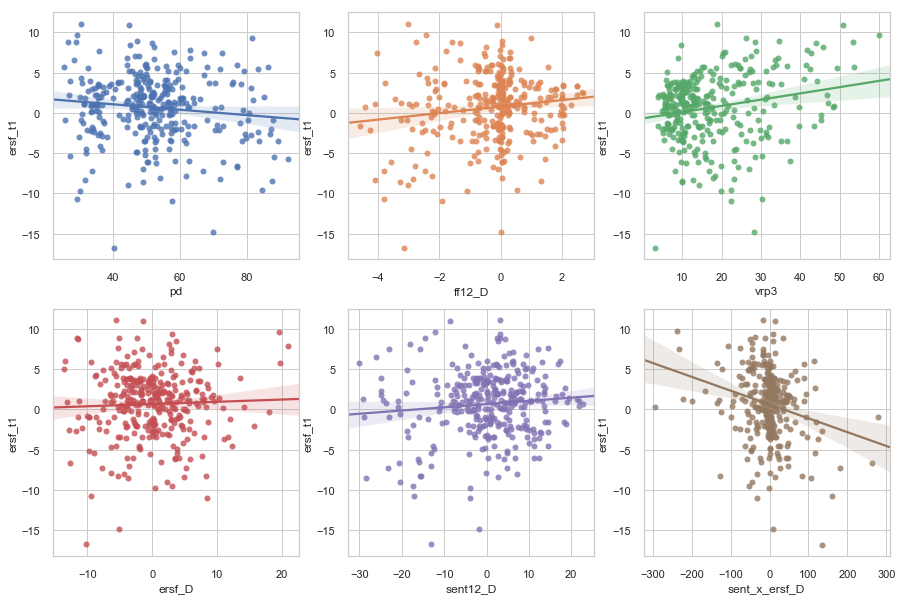

In [2567]:
sns.set(style='whitegrid', palette='deep')
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize=(15, 10))

sns.regplot(x='pd', y='ersf_t1', data=dfx, ax=axs[0,0])
sns.regplot(x='ff12_D', y='ersf_t1', data=dfx, ax=axs[0,1])
sns.regplot(x='vrp3', y='ersf_t1', data=dfx, ax=axs[0,2])
sns.regplot(x='ersf_D', y='ersf_t1', data=dfx, ax=axs[1,0])
sns.regplot(x='sent12_D', y='ersf_t1', data=dfx, ax=axs[1,1])
sns.regplot(x='sent_x_ersf_D', y='ersf_t1', data=dfx, ax=axs[1,2]);

In [2568]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

ind_variables = ['pd', 'ff12_D', 'vrp3', 'sent_x_ersf_D']
X = pd.DataFrame(dfx, columns=ind_variables)
y = pd.DataFrame(dfx, columns=['ersf_t1'])

lm = linear_model.LinearRegression()
model = lm.fit(X,y)

In [2569]:
predictions = model.predict(X)
print(predictions[0:5])

[[2.42316987]
 [2.22554093]
 [1.38518439]
 [0.91306669]
 [1.43130511]]


In [2570]:
lm.score(X,y), lm.coef_, lm.intercept_

(0.17516180906851953,
 array([[-0.05710409,  0.86531069,  0.11141535, -0.01394749]]),
 array([1.88787084]))

In [2571]:
google_trends_file = 'multiTimeline.csv'

google_data = pd.read_csv(google_trends_file)
google = pd.DataFrame(google_data)

In [2572]:
google = google[1:]

In [2573]:
#Create Filter for 2004 and Later
filt_2004 = (df['EOM'] >= '2004-01-01') & (df['EOM'] < '2018-01-01')
df04 = df[filt_2004]

#Fill the NaN value on the Target Variable with the Mean
df04.fillna(df04.mean(), inplace=True)
df04.tail(12)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,EOM,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D
336,2017-01-01,2278.870117,45.927877,0.000425,7.4651,0.65,98.5,49.618451,0.31,8.796700,6.5,1.916891,3.845262,-0.033886,-0.220260
337,2017-02-01,2363.639893,46.155150,0.000433,10.9366,0.66,96.3,51.210751,0.28,10.313433,4.6,3.845262,0.062941,1.928371,8.870506
338,2017-03-01,2362.719971,46.382424,0.000617,7.1965,0.79,96.9,50.939985,0.43,8.532733,5.9,0.062941,1.007029,-3.782321,-22.315693
339,2017-04-01,2384.199951,46.661289,0.000667,4.4930,0.90,97.0,51.095887,0.53,7.542033,8.0,1.007029,1.247525,0.944088,7.552702
340,2017-05-01,2411.800049,46.940154,0.000742,5.7031,0.91,97.1,51.380318,0.54,5.797533,2.4,1.247525,0.562864,0.240496,0.577191
341,2017-06-01,2423.409912,47.219019,0.000817,5.9955,1.04,95.0,51.322750,0.66,5.397200,1.5,0.562864,2.009181,-0.684662,-1.026992
342,2017-07-01,2470.300049,47.537047,0.000892,5.8568,1.15,93.4,51.965786,0.76,5.851800,3.4,2.009181,0.131911,1.446317,4.917478
343,2017-08-01,2471.649902,47.855075,0.000842,4.5638,1.16,96.8,51.648647,0.76,5.472033,7.0,0.131911,2.006883,-1.877269,-13.140885
344,2017-09-01,2519.360107,48.173103,0.000858,4.9171,1.15,95.1,52.298066,0.75,5.112567,3.9,2.006883,2.289827,1.874972,7.312391
345,2017-10-01,2575.260010,48.426075,0.000892,6.5894,1.15,100.7,53.179202,0.75,5.356767,13.5,2.289827,0.427026,0.282943,3.819735


In [2574]:
df04 = pd.concat([df04.reset_index(drop=True), google.reset_index(drop=True)], axis=1)

In [2575]:
df04 = df04.rename(columns={'Category: All categories': 'Google'})

In [2576]:
df04['Google'] = df04['Google'].astype('float64')

In [2577]:
df04["Google_D"] = df04['Google'] - df04['Google'].shift(1)
df04.head()

,EOM,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D,Google,Google_D
0,2004-01-01,1131.13,17.598000,0.000733,14.0860,1.00,103.8,64.276054,-0.24,16.151067,21.4,1.786198,1.274621,-3.352254,-71.738239,27.0,NaN
1,2004-02-01,1144.94,17.811000,0.000775,9.8728,1.01,94.4,64.282747,-0.25,14.917533,14.5,1.274621,-1.583041,-0.511577,-7.417861,27.0,0.0
2,2004-03-01,1126.21,18.024000,0.000783,9.4462,1.00,95.8,62.483910,-0.25,11.135000,18.2,-1.583041,-1.622623,-2.857662,-52.009454,27.0,0.0
3,2004-04-01,1107.30,18.216667,0.000783,13.4427,1.00,94.2,60.784995,-0.26,10.920567,8.2,-1.622623,1.261890,-0.039582,-0.324572,25.0,-2.0
4,2004-05-01,1120.68,18.409333,0.000850,5.2403,1.00,90.2,60.875643,-0.26,9.376400,-1.9,1.261890,1.831398,2.884513,-5.480574,21.0,-4.0


In [2578]:
df04.fillna(df04.mean(), inplace=True)
df04.head()

,EOM,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D,Google,Google_D
0,2004-01-01,1131.13,17.598000,0.000733,14.0860,1.00,103.8,64.276054,-0.24,16.151067,21.4,1.786198,1.274621,-3.352254,-71.738239,27.0,0.023952
1,2004-02-01,1144.94,17.811000,0.000775,9.8728,1.01,94.4,64.282747,-0.25,14.917533,14.5,1.274621,-1.583041,-0.511577,-7.417861,27.0,0.000000
2,2004-03-01,1126.21,18.024000,0.000783,9.4462,1.00,95.8,62.483910,-0.25,11.135000,18.2,-1.583041,-1.622623,-2.857662,-52.009454,27.0,0.000000
3,2004-04-01,1107.30,18.216667,0.000783,13.4427,1.00,94.2,60.784995,-0.26,10.920567,8.2,-1.622623,1.261890,-0.039582,-0.324572,25.0,-2.000000
4,2004-05-01,1120.68,18.409333,0.000850,5.2403,1.00,90.2,60.875643,-0.26,9.376400,-1.9,1.261890,1.831398,2.884513,-5.480574,21.0,-4.000000


In [2579]:
df04.corr()

,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D,Google,Google_D
Index,1.000000,0.926910,-0.197435,-0.377489,-0.189128,0.579347,0.091090,0.240900,-0.460633,0.233288,0.131134,0.020015,0.004965,0.056154,0.043981,0.030778
D12,0.926910,1.000000,-0.372532,-0.198381,-0.355154,0.361418,-0.283143,-0.030664,-0.265411,0.135172,0.042347,0.045339,0.014146,0.025965,0.197457,0.017756
Rfree,-0.197435,-0.372532,1.000000,-0.270263,0.991658,0.267316,0.477579,0.422660,-0.363454,-0.243364,-0.069381,-0.089303,-0.019006,0.050823,-0.092243,0.028209
VRP,-0.377489,-0.198381,-0.270263,1.000000,-0.268302,-0.483545,-0.468140,-0.371260,0.769026,-0.060501,-0.240775,0.210191,-0.122761,0.018431,0.021218,-0.094944
fed_funds,-0.189128,-0.355154,0.991658,-0.268302,1.000000,0.230430,0.448993,0.357401,-0.355477,-0.281639,-0.088243,-0.109466,-0.018672,0.047813,-0.068897,0.034335
ICS_ALL,0.579347,0.361418,0.267316,-0.483545,0.230430,1.000000,0.582132,0.635770,-0.599270,0.489859,0.109358,0.047514,-0.062101,0.015227,-0.082560,0.029741
pd,0.091090,-0.283143,0.477579,-0.468140,0.448993,0.582132,1.000000,0.706587,-0.512646,0.231991,0.195010,-0.075350,-0.030940,0.068783,-0.363363,0.032379
ff12_D,0.240900,-0.030664,0.422660,-0.371260,0.357401,0.635770,0.706587,1.000000,-0.418635,0.347842,0.212527,0.195731,-0.012541,0.034151,-0.338423,0.023657
vrp3,-0.460633,-0.265411,-0.363454,0.769026,-0.355477,-0.599270,-0.512646,-0.418635,1.000000,-0.004952,0.072134,0.294579,0.087702,-0.130402,0.047011,-0.046225
sent12_D,0.233288,0.135172,-0.243364,-0.060501,-0.281639,0.489859,0.231991,0.347842,-0.004952,1.000000,0.267856,0.197344,-0.049284,-0.064181,-0.233304,0.000506


In [2580]:
lr04_model= ols(formula='ersf_t1~pd+ff12_D+vrp3+sent_x_ersf_D+Google_D', data=df04).fit()
lr04_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ersf_t1   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     15.25
Date:                Fri, 19 Apr 2019   Prob (F-statistic):           2.87e-12
Time:                        09:35:50   Log-Likelihood:                -433.53
No. Observations:                 168   AIC:                             879.1
Df Residuals:                     162   BIC:                             897.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.2808      3.087      2.035      0.044       0.185      12.376
pd               -0.1482      0.057     -2.583      0.011      -0.261      -0.035
ff12_D            1.6502      0.284      5.813      0.000       1.090       2.211
vrp3              0.1402      0.029      4.758      0.000       0.082       0.198
sent_x_ersf_D    -0.0084      0.005     -1.849      0.066      -0.017       0.001
Google_D         -0.0889      0.027     -3.284      0.001      -0.142      -0.035
==============================================================================
Omnibus:                       10.578   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.929
Skew:                          -0.617   Prob(JB):                      0.00424
Kurtosis:                       3.193   Cond. No.                         724.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

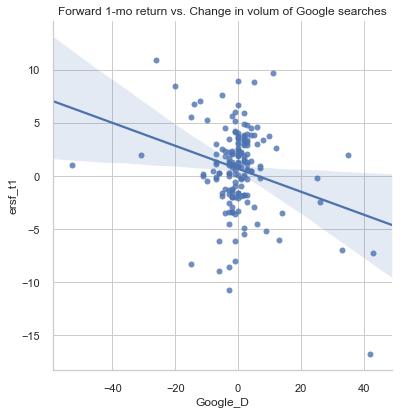

In [2663]:
sns.set_style('whitegrid')
ax = sns.lmplot( x='Google_D', y='ersf_t1', data=df04, fit_reg=True)
ax.fig.set_size_inches(6,6)
plt.title('Forward 1-mo return vs. Change in volum of Google searches')
plt.show();

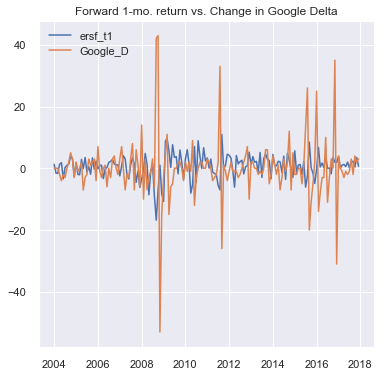

In [2667]:
x = df04['EOM']
y = df04[['ersf_t1', 'Google_D']]

sns.set()
fig = plt.figure(figsize=(6,6))
plt.plot(x, y)
plt.title('Forward 1-mo. return vs. Change in Google Delta')
plt.legend(y);

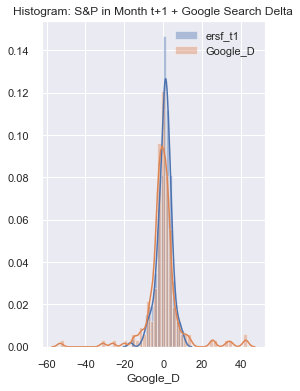

In [2669]:
sns.set()
fig = plt.figure(figsize=(4,6))
ax1 = sns.distplot(df04['ersf_t1'])
ax2 = sns.distplot(df04['Google_D']).set_title('Histogram: S&P in Month t+1 + Google Search Delta')
plt.legend(y);

In [2584]:
new_ind_variables = ['pd', 'ff12_D', 'vrp3', 'sent_x_ersf_D', 'Google_D']
new_X = pd.DataFrame(df04, columns=new_ind_variables)
new_y = pd.DataFrame(df04, columns=['ersf_t1'])

new_lm = linear_model.LinearRegression()
new_model = new_lm.fit(new_X,new_y)

In [2585]:
new_model.predict(new_X)

array([[-7.78131914e-01],
       [-1.50362008e+00],
       [-1.39500277e+00],
       [-1.44357879e+00],
       [-1.45255891e+00],
       [-1.59906409e+00],
       [-2.61886868e-01],
       [-4.27435499e-01],
       [-1.84038106e-01],
       [-6.20631556e-02],
       [-2.81323405e-02],
       [ 6.73048517e-01],
       [-7.14065924e-02],
       [ 9.46347070e-01],
       [ 1.24963375e+00],
       [ 1.80379038e+00],
       [ 2.90504752e+00],
       [ 2.40477756e+00],
       [ 1.94307944e+00],
       [ 1.49687533e+00],
       [ 2.09217347e+00],
       [ 1.72392899e+00],
       [ 2.39498652e+00],
       [ 2.42462922e+00],
       [ 1.58261406e+00],
       [ 2.09904698e+00],
       [ 2.30109671e+00],
       [ 1.90543127e+00],
       [ 1.93121591e+00],
       [ 2.97507254e+00],
       [ 2.49701675e+00],
       [ 2.03199156e+00],
       [ 1.38025124e+00],
       [ 6.28496652e-01],
       [ 8.28076309e-01],
       [ 5.76152475e-01],
       [-1.93987428e-01],
       [-6.93244257e-02],
       [-4.8

In [2586]:
predictions = new_model.predict(new_X)
predictions[0:5]

array([[-0.77813191],
       [-1.50362008],
       [-1.39500277],
       [-1.44357879],
       [-1.45255891]])

In [2587]:
new_model.score(new_X, new_y)

0.3199810425959896

In [2588]:
%matplotlib inline
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import ProbPlot

plt.style.use('seaborn') # pretty matplotlib plots

plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [2589]:
df04.reset_index(drop=True, inplace=True)
df04.head()

,EOM,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D,Google,Google_D
0,2004-01-01,1131.13,17.598000,0.000733,14.0860,1.00,103.8,64.276054,-0.24,16.151067,21.4,1.786198,1.274621,-3.352254,-71.738239,27.0,0.023952
1,2004-02-01,1144.94,17.811000,0.000775,9.8728,1.01,94.4,64.282747,-0.25,14.917533,14.5,1.274621,-1.583041,-0.511577,-7.417861,27.0,0.000000
2,2004-03-01,1126.21,18.024000,0.000783,9.4462,1.00,95.8,62.483910,-0.25,11.135000,18.2,-1.583041,-1.622623,-2.857662,-52.009454,27.0,0.000000
3,2004-04-01,1107.30,18.216667,0.000783,13.4427,1.00,94.2,60.784995,-0.26,10.920567,8.2,-1.622623,1.261890,-0.039582,-0.324572,25.0,-2.000000
4,2004-05-01,1120.68,18.409333,0.000850,5.2403,1.00,90.2,60.875643,-0.26,9.376400,-1.9,1.261890,1.831398,2.884513,-5.480574,21.0,-4.000000


In [2590]:
model_f = 'ersf_t1 ~ pd + \
                 ff12_D + \
                 vrp3 + \
                 sent_x_ersf_D + \
                 Google_D'

model = smf.ols(formula=model_f, data=df04)
model_fit = model.fit()

In [2591]:
model_fit.params

Intercept        6.280774
pd              -0.148179
ff12_D           1.650177
vrp3             0.140208
sent_x_ersf_D   -0.008352
Google_D        -0.088948
dtype: float64

In [2592]:
# fitted values (need a constant term for intercept)
model_fitted_y = model_fit.fittedvalues

# model residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

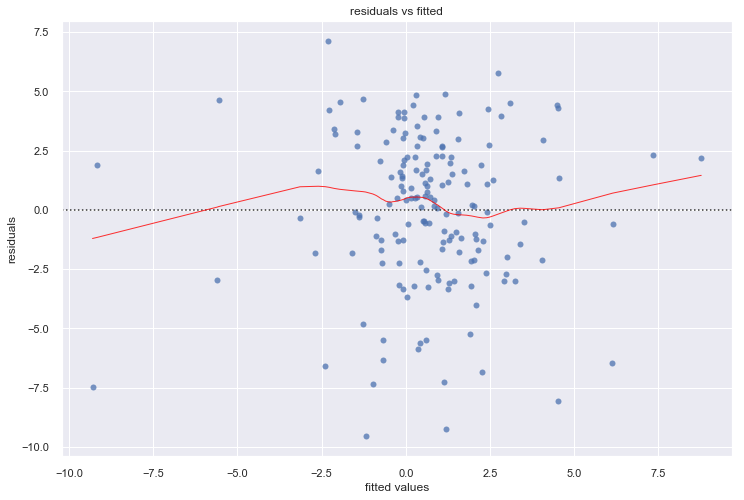

In [2675]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'ersf_t1', data=df04, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.75}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('residuals vs fitted')
plot_lm_1.axes[0].set_xlabel('fitted values')
plot_lm_1.axes[0].set_ylabel('residuals');

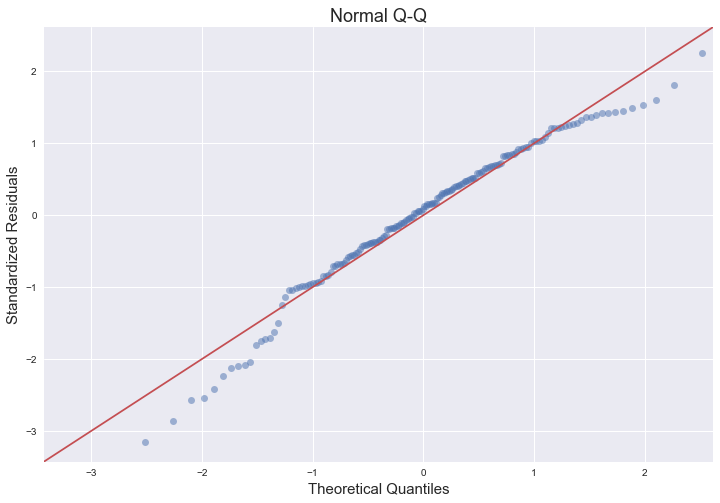

In [2594]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

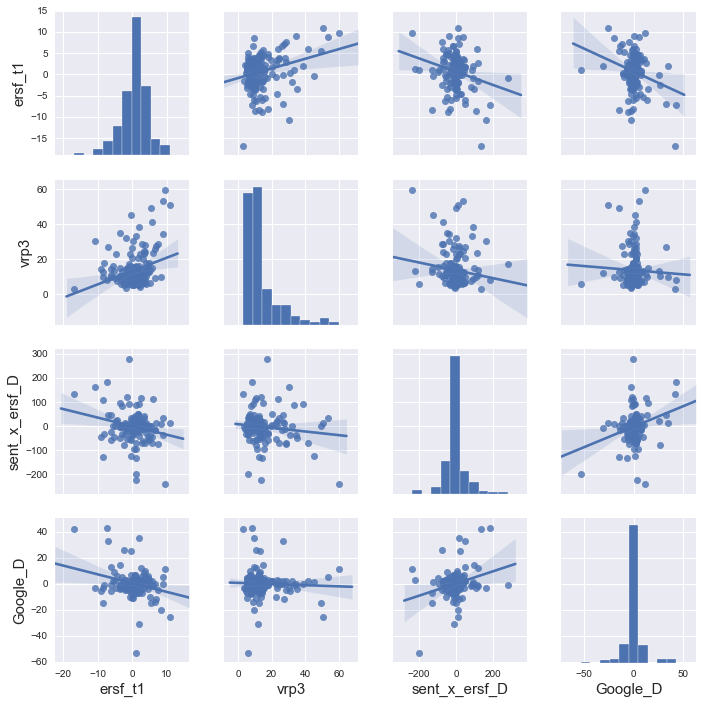

In [2595]:
sns.pairplot(df04, vars=['ersf_t1','vrp3', 'sent_x_ersf_D', 'Google_D'],
                 kind='reg');

<Figure size 864x864 with 0 Axes>

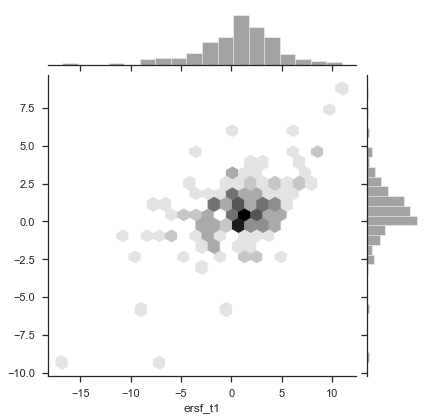

In [2596]:
sns.set(style="ticks")
fig = plt.figure(figsize=(12, 12))

x = df04['ersf_t1']
y = model_fitted_y

sns.jointplot(x, y, kind="hex", color="k");

In [2597]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df04['ersf_t1'], model_fitted_y)
mse

10.207680585297423

In [2598]:
f2018 = '^GSPC.csv'
data = pd.read_csv(f2018)
sp18 = pd.DataFrame(data)
sp18.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,2683.729980,2872.870117,2682.360107,2823.810059,2823.810059,76860120000
1,2018-02-01,2816.449951,2835.959961,2532.689941,2713.830078,2713.830078,79579410000
2,2018-03-01,2715.219971,2801.899902,2585.889893,2640.870117,2640.870117,76369800000
3,2018-04-01,2633.449951,2717.489990,2553.800049,2648.050049,2648.050049,69648590000
4,2018-05-01,2642.959961,2742.239990,2594.620117,2705.270020,2705.270020,75617280000


In [2599]:
sp18 = sp18[['Date', 'Close', 'Volume']]

In [2600]:
vrp18 = pd.read_fwf('VRPtable.txt')
df_vrp18 = pd.DataFrame(vrp18)

In [2601]:
df_vrp18 = df_vrp18[df_vrp18['Year'] >= 2018]
df_vrp18 = df_vrp18[['VRP']]

In [2602]:
sp18 = pd.concat([sp18.reset_index(drop=True), df_vrp18.reset_index(drop=True)], axis=1)

In [2603]:
risk_free_df = risk_free_df['return']
sp18 = pd.concat([sp18.reset_index(drop=True), risk_free_df.reset_index(drop=True)], axis=1)
sp18 = sp18.rename(columns={'return': 'Rfree'})

In [2604]:
sp18.head()

,Date,Close,Volume,VRP,Rfree
0,2018-01-01,2823.810059,76860120000,10.0329,0.001200
1,2018-02-01,2713.830078,79579410000,-5.9018,0.001358
2,2018-03-01,2640.870117,76369800000,8.6653,0.001417
3,2018-04-01,2648.050049,69648590000,-1.9751,0.001533
4,2018-05-01,2705.270020,75617280000,9.4048,0.001575


In [2605]:
fed_funds_df = fed_funds_df['return']
sp18 = pd.concat([sp18.reset_index(drop=True), fed_funds_df.reset_index(drop=True)], axis=1)

In [2606]:
sp18 = sp18.rename(columns={'return': 'fed_funds'})

In [2607]:
sp18.head()

,Date,Close,Volume,VRP,Rfree,fed_funds
0,2018-01-01,2823.810059,76860120000,10.0329,0.001200,0.001175
1,2018-02-01,2713.830078,79579410000,-5.9018,0.001358,0.001183
2,2018-03-01,2640.870117,76369800000,8.6653,0.001417,0.001258
3,2018-04-01,2648.050049,69648590000,-1.9751,0.001533,0.001408
4,2018-05-01,2705.270020,75617280000,9.4048,0.001575,0.001417


In [2608]:
dividends18 = '2018_Divident History.csv'
div_data18 = pd.read_csv(dividends)
div18 = pd.DataFrame(div_data18)

In [2609]:
div18 = div18[['Value']]
div18 = div18.rename(columns={'Value': 'D12'})

In [2610]:
sp18 = pd.concat([sp18.reset_index(drop=True), div18.reset_index(drop=True)], axis=1)
sp18 = sp18.rename(columns={'Close': 'Index', 'Date': 'EOM'})
sp18 = sp18.drop(columns=['Volume'])
sp18['EOM'] = pd.to_datetime(sp18['EOM'])


In [2611]:
sp18.head()
df17.head()

,EOM,Index,VRP,Rfree,fed_funds,D12
0,2018-01-01,2823.810059,10.0329,0.001200,0.001175,50.55
1,2018-02-01,2713.830078,-5.9018,0.001358,0.001183,50.69
2,2018-03-01,2640.870117,8.6653,0.001417,0.001258,50.93
3,2018-04-01,2648.050049,-1.9751,0.001533,0.001408,51.07
4,2018-05-01,2705.270020,9.4048,0.001575,0.001417,51.19


,EOM,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D
336,2017-01-01,2278.870117,45.927877,0.000425,7.4651,0.65,98.5,49.618451,0.31,8.796700,6.5,1.916891,3.845262,-0.033886,-0.220260
337,2017-02-01,2363.639893,46.155150,0.000433,10.9366,0.66,96.3,51.210751,0.28,10.313433,4.6,3.845262,0.062941,1.928371,8.870506
338,2017-03-01,2362.719971,46.382424,0.000617,7.1965,0.79,96.9,50.939985,0.43,8.532733,5.9,0.062941,1.007029,-3.782321,-22.315693
339,2017-04-01,2384.199951,46.661289,0.000667,4.4930,0.90,97.0,51.095887,0.53,7.542033,8.0,1.007029,1.247525,0.944088,7.552702
340,2017-05-01,2411.800049,46.940154,0.000742,5.7031,0.91,97.1,51.380318,0.54,5.797533,2.4,1.247525,0.562864,0.240496,0.577191


In [2612]:
sp18.head()

,EOM,Index,VRP,Rfree,fed_funds,D12
0,2018-01-01,2823.810059,10.0329,0.001200,0.001175,50.55
1,2018-02-01,2713.830078,-5.9018,0.001358,0.001183,50.69
2,2018-03-01,2640.870117,8.6653,0.001417,0.001258,50.93
3,2018-04-01,2648.050049,-1.9751,0.001533,0.001408,51.07
4,2018-05-01,2705.270020,9.4048,0.001575,0.001417,51.19


In [2613]:
sentiment_file18 = 'tbmics.csv'
sentiment18 = pd.read_csv(sentiment_file18)

In [2614]:
sentiment18 = sentiment18[(sentiment18['YYYY'] >= 2018) & (sentiment18['YYYY'] < 2019)]
sentiment18 = sentiment18['ICS_ALL']
sp18 = pd.concat([sp18.reset_index(drop=True), sentiment18.reset_index(drop=True)], axis=1)

In [2615]:
sp18

,EOM,Index,VRP,Rfree,fed_funds,D12,ICS_ALL
0,2018-01-01,2823.810059,10.0329,0.001200,0.001175,50.55,95.7
1,2018-02-01,2713.830078,-5.9018,0.001358,0.001183,50.69,99.7
2,2018-03-01,2640.870117,8.6653,0.001417,0.001258,50.93,101.4
3,2018-04-01,2648.050049,-1.9751,0.001533,0.001408,51.07,98.8
4,2018-05-01,2705.270020,9.4048,0.001575,0.001417,51.19,98.0
5,2018-06-01,2718.370117,13.2745,0.001575,0.001517,51.44,98.2
6,2018-07-01,2816.290039,8.1409,0.001658,0.001592,51.89,97.9
7,2018-08-01,2901.520020,8.5030,0.001725,0.001592,52.31,96.2
8,2018-09-01,2913.979980,7.9528,0.001792,0.001625,52.70,100.1
9,2018-10-01,2711.739990,-2.2509,0.001908,0.001825,53.08,98.6


In [2616]:
#Number of Periods in Variance Risk Premium
vrp_rolling_periods = 3

#Calculate Gross Nominal Return
#gross_nominal_return_1 = ((df['Index'] + (df['D12'] / 12)) - df['Index'].shift(1)) / df['Index'].shift(1)
#gross_nominal_return_2 = ((df['Index'] + df['D12'] / 12))/ df['Index'].shift(1) - 1

#Calculate Price Dividend Ratio
price_dividend_ratio = (sp18['Index'] / sp18['D12'])

#Calculate Fed Funds Rate Delta
fed_funds_delta_formula = sp18['fed_funds'] - sp18['fed_funds'].shift(12)

#Calculate Variance Risk Premium Rolling
rolling_vrp_formula = sp18['VRP'].rolling(vrp_rolling_periods).mean()

#Calculate Sentiment Delta
sent_delta_formula = (sp18['ICS_ALL'] - sp18['ICS_ALL'].shift(12));

In [2617]:
#Create Column with Gross Nominal Return
#df['g_nominal_return'] = gross_nominal_return_1

#Create Column with PD Ratio
sp18['pd'] = price_dividend_ratio

#Create Column with Fed Funds Rate Delta (12 Month)
sp18['ff12_D'] = fed_funds_delta_formula

#Create Column with Rolling Variance Risk Premium Rolling
sp18['vrp3'] = rolling_vrp_formula

#Create Column with Sentiment Delta
sp18['sent12_D'] = sent_delta_formula

#Create Column with Excess Return on Index Relative to the RFR in percent
sp18['ersf'] = (((sp18['Index'] + sp18['D12']/12 - sp18['Index'].shift(1)) / sp18['Index'].shift(1)) - sp18['Rfree']) * 100

#Create Column with Excess Return on Index Relative to the RFR in percent
sp18['ersf_t1'] = (((sp18['Index'].shift(-1) + sp18['D12'].shift(-1)/12 - sp18['Index']) / sp18['Index']) - sp18['Rfree'].shift(-1)) * 100

#Create Column with 1-month Delta in ersf
sp18['ersf_D'] = sp18['ersf'] - sp18['ersf'].shift(1)

#Create column with Sentiment X ersf Delta
sp18['sent_x_ersf_D'] = sp18['sent12_D'] * sp18['ersf_D']

In [2618]:
sp18 = sp18[['EOM', 'Index', 'D12', 'Rfree', 'VRP', 'fed_funds', 'ICS_ALL', 'pd', 'ff12_D', 'vrp3', 'sent12_D', 'ersf', 'ersf_t1', 'ersf_D', 'sent_x_ersf_D']]

In [2619]:
sp18.head()
df17.head()

,EOM,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D
0,2018-01-01,2823.810059,50.55,0.001200,10.0329,0.001175,95.7,55.861722,NaN,NaN,NaN,NaN,-3.880980,NaN,NaN
1,2018-02-01,2713.830078,50.69,0.001358,-5.9018,0.001183,99.7,53.537780,NaN,NaN,NaN,-3.880980,-2.673726,NaN,NaN
2,2018-03-01,2640.870117,50.93,0.001417,8.6653,0.001258,101.4,51.852938,NaN,4.265467,NaN,-2.673726,0.279697,1.207253,NaN
3,2018-04-01,2648.050049,51.07,0.001533,-1.9751,0.001408,98.8,51.851381,NaN,0.262800,NaN,0.279697,2.164428,2.953423,NaN
4,2018-05-01,2705.270020,51.19,0.001575,9.4048,0.001417,98.0,52.847627,NaN,5.365000,NaN,2.164428,0.485200,1.884731,NaN


,EOM,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D
336,2017-01-01,2278.870117,45.927877,0.000425,7.4651,0.65,98.5,49.618451,0.31,8.796700,6.5,1.916891,3.845262,-0.033886,-0.220260
337,2017-02-01,2363.639893,46.155150,0.000433,10.9366,0.66,96.3,51.210751,0.28,10.313433,4.6,3.845262,0.062941,1.928371,8.870506
338,2017-03-01,2362.719971,46.382424,0.000617,7.1965,0.79,96.9,50.939985,0.43,8.532733,5.9,0.062941,1.007029,-3.782321,-22.315693
339,2017-04-01,2384.199951,46.661289,0.000667,4.4930,0.90,97.0,51.095887,0.53,7.542033,8.0,1.007029,1.247525,0.944088,7.552702
340,2017-05-01,2411.800049,46.940154,0.000742,5.7031,0.91,97.1,51.380318,0.54,5.797533,2.4,1.247525,0.562864,0.240496,0.577191


In [2620]:
sp18 = pd.concat([df17.reset_index(drop=True), sp18.reset_index(drop=True)], axis=0)

In [2621]:
#Number of Periods in Variance Risk Premium
vrp_rolling_periods = 3

#Calculate Gross Nominal Return
#gross_nominal_return_1 = ((df['Index'] + (df['D12'] / 12)) - df['Index'].shift(1)) / df['Index'].shift(1)
#gross_nominal_return_2 = ((df['Index'] + df['D12'] / 12))/ df['Index'].shift(1) - 1

#Calculate Price Dividend Ratio
price_dividend_ratio = (sp18['Index'] / sp18['D12'])

#Calculate Fed Funds Rate Delta - MADE ROLLING 11 SO CAN PREDICT 2018-01
fed_funds_delta_formula = sp18['fed_funds'] - sp18['fed_funds'].shift(11)

#Calculate Variance Risk Premium Rolling
rolling_vrp_formula = sp18['VRP'].rolling(vrp_rolling_periods).mean()

#Calculate Sentiment Delta - MADE ROLLING 11 SO CAN PREDICT 2018-01
sent_delta_formula = (sp18['ICS_ALL'] - sp18['ICS_ALL'].shift(11))

#Create Column with PD Ratio
sp18['pd'] = price_dividend_ratio

#Create Column with Fed Funds Rate Delta (12 Month)
sp18['ff12_D'] = fed_funds_delta_formula

#Create Column with Rolling Variance Risk Premium Rolling
sp18['vrp3'] = rolling_vrp_formula

#Create Column with Sentiment Delta
sp18['sent12_D'] = sent_delta_formula

#Create Column with Excess Return on Index Relative to the RFR in percent
sp18['ersf'] = (((sp18['Index'] + sp18['D12']/12 - sp18['Index'].shift(1)) / sp18['Index'].shift(1)) - sp18['Rfree']) * 100

#Create Column with Excess Return on Index Relative to the RFR in percent
sp18['ersf_t1'] = (((sp18['Index'].shift(-1) + sp18['D12'].shift(-1)/12 - sp18['Index']) / sp18['Index']) - sp18['Rfree'].shift(-1)) * 100

#Create Column with 1-month Delta in ersf
sp18['ersf_D'] = sp18['ersf'] - sp18['ersf'].shift(1)

#Create column with Sentiment X ersf Delta
sp18['sent_x_ersf_D'] = sp18['sent12_D'] * sp18['ersf_D']

In [2622]:
sp18

,EOM,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D
0,2017-01-01,2278.870117,45.927877,0.000425,7.4651,0.650000,98.5,49.618451,NaN,NaN,NaN,NaN,3.845262,NaN,NaN
1,2017-02-01,2363.639893,46.155150,0.000433,10.9366,0.660000,96.3,51.210751,NaN,NaN,NaN,3.845262,0.062941,NaN,NaN
2,2017-03-01,2362.719971,46.382424,0.000617,7.1965,0.790000,96.9,50.939985,NaN,8.532733,NaN,0.062941,1.007029,-3.782321,NaN
3,2017-04-01,2384.199951,46.661289,0.000667,4.4930,0.900000,97.0,51.095887,NaN,7.542033,NaN,1.007029,1.247525,0.944088,NaN
4,2017-05-01,2411.800049,46.940154,0.000742,5.7031,0.910000,97.1,51.380318,NaN,5.797533,NaN,1.247525,0.562864,0.240496,NaN
5,2017-06-01,2423.409912,47.219019,0.000817,5.9955,1.040000,95.0,51.322750,NaN,5.397200,NaN,0.562864,2.009181,-0.684662,NaN
6,2017-07-01,2470.300049,47.537047,0.000892,5.8568,1.150000,93.4,51.965786,NaN,5.851800,NaN,2.009181,0.131911,1.446317,NaN
7,2017-08-01,2471.649902,47.855075,0.000842,4.5638,1.160000,96.8,51.648647,NaN,5.472033,NaN,0.131911,2.006883,-1.877269,NaN
8,2017-09-01,2519.360107,48.173103,0.000858,4.9171,1.150000,95.1,52.298066,NaN,5.112567,NaN,2.006883,2.289827,1.874972,NaN
9,2017-10-01,2575.260010,48.426075,0.000892,6.5894,1.150000,100.7,53.179202,NaN,5.356767,NaN,2.289827,0.427026,0.282943,NaN


In [2623]:
google_2018f = 'multiTimeline (2).csv'
goog_2018 = pd.read_csv(google_2018f)
google_2018 = pd.DataFrame(goog_2018)
google_2018 = google_2018[1:]

In [2624]:
google_2018 = google_2018[-24:]

In [2625]:
google_2018 = google_2018.astype('float64')

In [2626]:
sp18 = pd.concat([sp18.reset_index(drop=True), google_2018.reset_index(drop=True)], axis=1)
sp18 = sp18.rename(columns={'Category: All categories': 'Google'})

In [2627]:
sp18['Google_D'] = sp18['Google'] - sp18['Google'].shift(1)

In [2628]:
sp18

,EOM,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D,Google,Google_D
0,2017-01-01,2278.870117,45.927877,0.000425,7.4651,0.650000,98.5,49.618451,NaN,NaN,NaN,NaN,3.845262,NaN,NaN,31.0,NaN
1,2017-02-01,2363.639893,46.155150,0.000433,10.9366,0.660000,96.3,51.210751,NaN,NaN,NaN,3.845262,0.062941,NaN,NaN,31.0,0.0
2,2017-03-01,2362.719971,46.382424,0.000617,7.1965,0.790000,96.9,50.939985,NaN,8.532733,NaN,0.062941,1.007029,-3.782321,NaN,32.0,1.0
3,2017-04-01,2384.199951,46.661289,0.000667,4.4930,0.900000,97.0,51.095887,NaN,7.542033,NaN,1.007029,1.247525,0.944088,NaN,27.0,-5.0
4,2017-05-01,2411.800049,46.940154,0.000742,5.7031,0.910000,97.1,51.380318,NaN,5.797533,NaN,1.247525,0.562864,0.240496,NaN,26.0,-1.0
5,2017-06-01,2423.409912,47.219019,0.000817,5.9955,1.040000,95.0,51.322750,NaN,5.397200,NaN,0.562864,2.009181,-0.684662,NaN,24.0,-2.0
6,2017-07-01,2470.300049,47.537047,0.000892,5.8568,1.150000,93.4,51.965786,NaN,5.851800,NaN,2.009181,0.131911,1.446317,NaN,23.0,-1.0
7,2017-08-01,2471.649902,47.855075,0.000842,4.5638,1.160000,96.8,51.648647,NaN,5.472033,NaN,0.131911,2.006883,-1.877269,NaN,27.0,4.0
8,2017-09-01,2519.360107,48.173103,0.000858,4.9171,1.150000,95.1,52.298066,NaN,5.112567,NaN,2.006883,2.289827,1.874972,NaN,23.0,-4.0
9,2017-10-01,2575.260010,48.426075,0.000892,6.5894,1.150000,100.7,53.179202,NaN,5.356767,NaN,2.289827,0.427026,0.282943,NaN,29.0,6.0


In [2629]:
filt_2018 = (sp18['EOM'] >= '2017-12-01') & (sp18['EOM'] < '2019-01-01')
sp18x = sp18[filt_2018]

In [2630]:
sp18xxx = sp18x[['EOM', 'Index', 'ersf', 'sent12_D']]

In [2631]:
ind_variables = ['pd', 'ff12_D', 'vrp3', 'sent_x_ersf_D', 'Google_D']
X = pd.DataFrame(sp18x, columns=new_ind_variables)

In [2632]:
X.reset_index(drop=True)

,pd,ff12_D,vrp3,sent_x_ersf_D,Google_D
0,54.639276,0.650000,6.556300,-7.942956,3.0
1,55.861722,-0.658825,7.704133,-1.304052,9.0
2,53.537780,-0.788817,3.412800,-26.701944,44.0
3,51.852938,-0.898742,4.265467,5.311914,-39.0
4,51.851381,-0.908592,0.262800,5.020819,-5.0
5,52.847627,-1.038583,5.365000,5.654192,-12.0
6,52.845453,-1.148483,6.901400,-8.060294,0.0
7,54.274235,-1.158408,10.273400,3.421214,0.0
8,55.467789,-1.148408,9.972800,-0.645468,1.0
9,55.293738,-1.148375,8.198900,1.564191,-1.0


In [2633]:
predictions_2018 = new_model.predict(X)
predictions_2018

array([[-0.02426935],
       [-2.79340014],
       [-6.16629164],
       [ 1.13682756],
       [-2.462197  ],
       [-1.49161512],
       [-2.41006919],
       [-2.26126998],
       [-2.51875915],
       [-2.58218657],
       [-5.1100036 ],
       [-2.12730376],
       [-3.14369371]])

In [2634]:
list_of_predictions = []
for i in predictions_2018.tolist():
    list_of_predictions.append(i[0])
    
df_predictions = pd.DataFrame(list_of_predictions)
df_predictions = df_predictions.rename(columns={0: 'pred_ret_next_mo'})

In [2635]:
df_summary = X
df_summary = pd.concat([df_summary.reset_index(drop=True), df_predictions.reset_index(drop=True)], axis=1)

In [2636]:
df_summary = pd.concat([sp18xxx.reset_index(drop=True), df_summary.reset_index(drop=True)], axis=1)

In [2637]:
df_summary

,EOM,Index,ersf,sent12_D,pd,ff12_D,vrp3,sent_x_ersf_D,Google_D,pred_ret_next_mo
0,2017-12-01,2673.610107,3.482009,-2.6,54.639276,0.650000,6.556300,-7.942956,3.0,-0.024269
1,2018-01-01,2823.810059,5.655429,-0.6,55.861722,-0.658825,7.704133,-1.304052,9.0,-2.793400
2,2018-02-01,2713.830078,-3.880980,2.8,53.537780,-0.788817,3.412800,-26.701944,44.0,-6.166292
3,2018-03-01,2640.870117,-2.673726,4.4,51.852938,-0.898742,4.265467,5.311914,-39.0,1.136828
4,2018-04-01,2648.050049,0.279697,1.7,51.851381,-0.908592,0.262800,5.020819,-5.0,-2.462197
5,2018-05-01,2705.270020,2.164428,3.0,52.847627,-1.038583,5.365000,5.654192,-12.0,-1.491615
6,2018-06-01,2718.370117,0.485200,4.8,52.845453,-1.148483,6.901400,-8.060294,0.0,-2.410069
7,2018-07-01,2816.290039,3.595394,1.1,54.274235,-1.158408,10.273400,3.421214,0.0,-2.261270
8,2018-08-01,2901.520020,3.008605,1.1,55.467789,-1.148408,9.972800,-0.645468,1.0,-2.518759
9,2018-09-01,2913.979980,0.401619,-0.6,55.293738,-1.148375,8.198900,1.564191,-1.0,-2.582187


In [2638]:
model_fit.params

Intercept        6.280774
pd              -0.148179
ff12_D           1.650177
vrp3             0.140208
sent_x_ersf_D   -0.008352
Google_D        -0.088948
dtype: float64

In [2639]:
B0 = model_fit.params['Intercept'] 
Bpd = model_fit.params['pd'] 
Bff = model_fit.params['ff12_D'] 
Bvrp = model_fit.params['vrp3']
Bse = model_fit.params['sent_x_ersf_D']
Bg = model_fit.params['Google_D']

In [2640]:
for i in range(len(df_summary)):
    prediction = B0 + (Bpd * df_summary.iloc[i]['pd']) \
                + (Bff * df_summary.iloc[i]['ff12_D']) \
                + (Bvrp * df_summary.iloc[i]['vrp3'])  \
                + (Bse * df_summary.iloc[i]['sent_x_ersf_D']) \
                + (Bg * df_summary.iloc[i]['Google_D']) \
    
    print(prediction)

-0.02426934637765052
-2.793400139741159
-6.166291637209399
1.1368275624903976
-2.4621969982265584
-1.4916151195378753
-2.410069193155646
-2.261269983194259
-2.518759153367949
-2.582186572068237
-5.110003601641441
-2.1273037627856617
-3.143693707213781


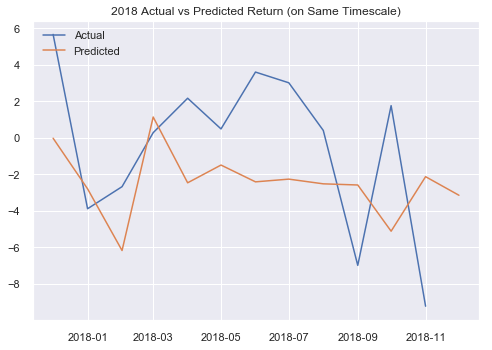

In [2657]:
sns.set()
x = sp18x['EOM']

plt.plot(x, sp18x['ersf'].shift(-1))
plt.plot(x, predictions_2018)

plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.title('2018 Actual vs Predicted Return (on Same Timescale)')

plt.show();
